#Generative Dog Images

Use your training skills to create images, rather than identify them. I’ll be using GANs, which are at the creative frontier of machine learning. You might think of GANs as robot artists in a sense—able to create eerily lifelike images, and even digital worlds.


A generative adversarial network (GAN) is a class of machine learning system invented by Ian Goodfellow in 2014. Two neural networks compete with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set.

In this competition, I’ll be training generative models to create images of dogs. Only this time… there’s no ground truth data for you to predict. Here, you’ll submit the images and be scored based on how well those images are classified as dogs from pre-trained neural networks.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/c/generative-dog-images/data')

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
from wordcloud import WordCloud



In [5]:
import zipfile
import os

# Path to the zip file
zip_path = './generative-dog-images/all-dogs.zip'


# Directory where you want to extract the images
extract_to = './generative-dog-images/data'

# Create a directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping done! 🎉")


Unzipping done! 🎉


In [6]:
zip_path2 = './generative-dog-images/Annotation.zip'
with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


#Exploratory Data Analysis

Total images: 20579 🖼️


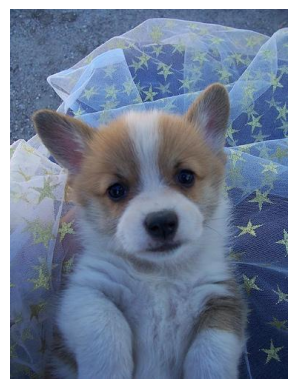

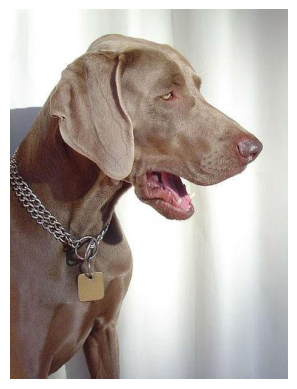

In [7]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# List all files in the unzipped directory
dogfolder = './generative-dog-images/data/all-dogs'
file_list = os.listdir(dogfolder)
print(f"Total images: {len(file_list)} 🖼️")

# Display a few images
for _ in range(2):
    img_path = os.path.join(dogfolder, random.choice(file_list))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [8]:
import xml.etree.ElementTree as ET

# Function to parse the XML annotation file
def parse_annotation(ann_file):
    tree = ET.parse(ann_file)
    root = tree.getroot()
    bndbox = root.find('object/bndbox')
    return {
        'breed': root.find('object/name').text,
        'bbox': {
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text)
        }
    }

# Example usage:
annotation_path = './generative-dog-images/data/Annotation/n02085620-Chihuahua/n02085620_10074'
info = parse_annotation(annotation_path)
print(info)  # This will print the breed and bounding box details


{'breed': 'Chihuahua', 'bbox': {'xmin': 25, 'ymin': 10, 'xmax': 276, 'ymax': 498}}


the number of image files 20579 
the number of Breed 120 


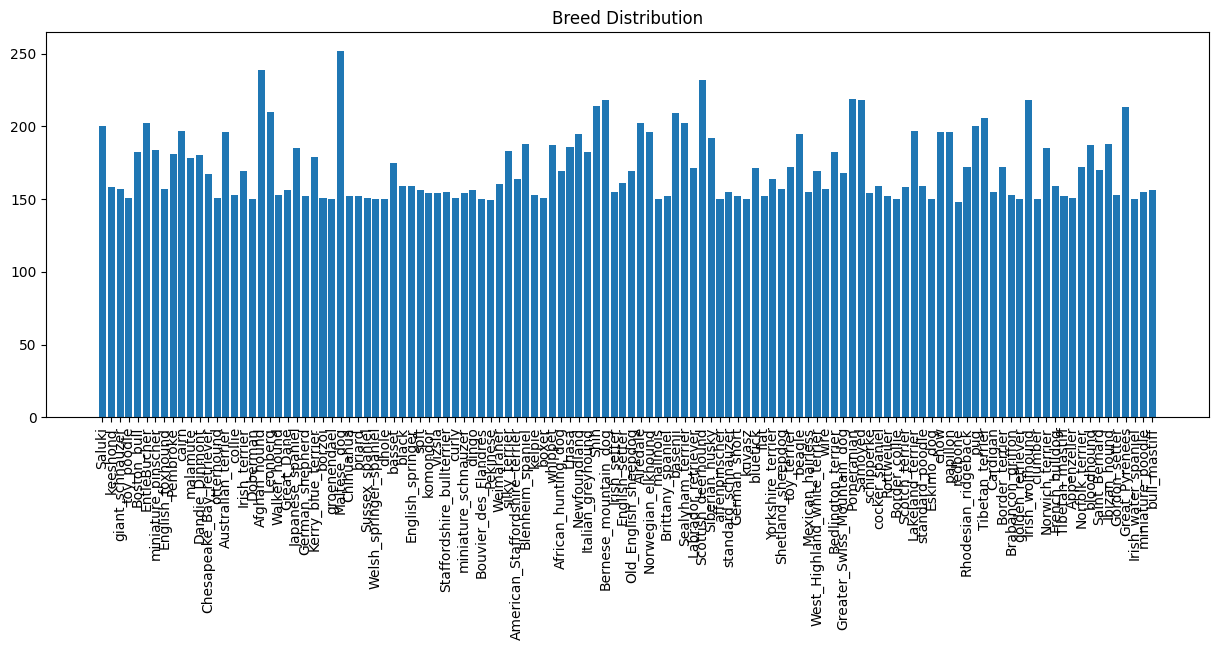

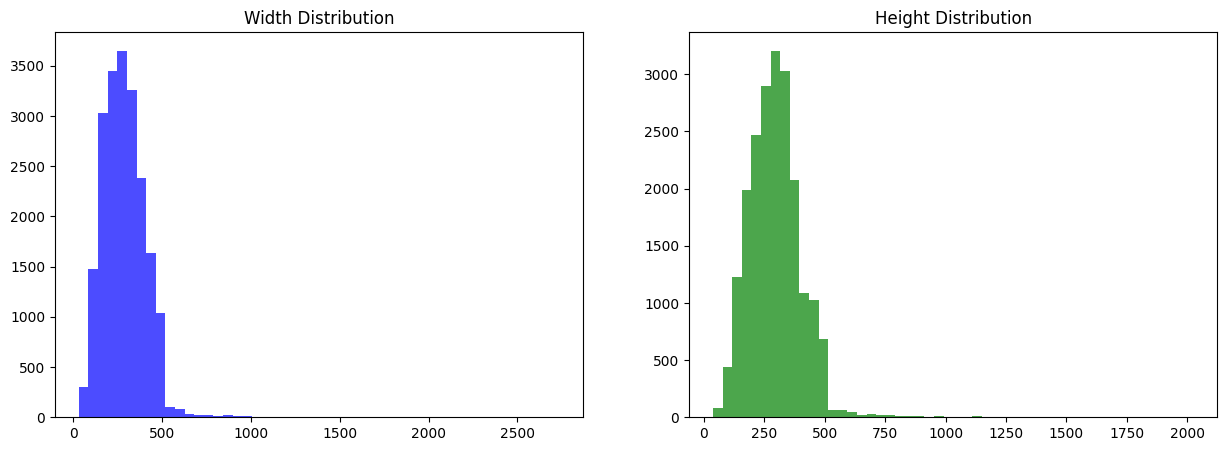

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import xml.etree.ElementTree as ET
import numpy as np


# Load images and annotations paths
images_path = './generative-dog-images/data/all-dogs/'
annotations_path = './generative-dog-images/data/Annotation/'

# Analyzing breeds
breed_counts = {}
for ann_dir in os.listdir(annotations_path):
    breed = ann_dir.split("-")[1]
    breed_counts[breed] = len(os.listdir(os.path.join(annotations_path, ann_dir)))

# The number of images
def extract_breed(folder_name):
    return folder_name.split('-')[1]

# Get a list of all dog images
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]


print(f"the number of image files {len(image_files)} ")

# The number of unique breed types
print(f"the number of Breed {len(breed_counts)} ")


# Plot breed distribution
plt.figure(figsize=(15, 5))
plt.bar(breed_counts.keys(), breed_counts.values())
plt.title('Breed Distribution')
plt.xticks(rotation=90)
plt.show()

# Image sizes
widths = []
heights = []
for ann_dir in os.listdir(annotations_path):
    for ann_file in os.listdir(os.path.join(annotations_path, ann_dir)):
        ann_path = os.path.join(annotations_path, ann_dir, ann_file)
        info = parse_annotation(ann_path)
        widths.append(info['bbox']['xmax'] - info['bbox']['xmin'])
        heights.append(info['bbox']['ymax'] - info['bbox']['ymin'])

# Plot size distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color='blue', alpha=0.7)
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, color='green', alpha=0.7)
plt.title('Height Distribution')
plt.show()


In [10]:
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

def parse_annotation(ann_file):
    tree = ET.parse(ann_file)
    root = tree.getroot()
    bndbox = root.find('object/bndbox')
    return {
        'xmin': int(bndbox.find('xmin').text),
        'ymin': int(bndbox.find('ymin').text),
        'xmax': int(bndbox.find('xmax').text),
        'ymax': int(bndbox.find('ymax').text)
    }

def preprocess_images(image_dir, annotation_dir, target_size=(64, 64)):
    processed_images = []
    for ann_folder in os.listdir(annotation_dir):
        for ann_file in os.listdir(os.path.join(annotation_dir, ann_folder)):
            # Get the corresponding image file
            image_file = ann_file + '.jpg'
            image_path = os.path.join(image_dir, image_file)
            ann_path = os.path.join(annotation_dir, ann_folder, ann_file)

            # If the image file exists
            if os.path.exists(image_path):
                # Parse the annotation to get the bounding box
                bbox = parse_annotation(ann_path)

                # Open the image and crop it using the bounding box
                with Image.open(image_path) as img:
                    img_cropped = img.crop((bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']))

                    # Resize the cropped image to the target size
                    img_resized = img_cropped.resize(target_size, Image.Resampling.LANCZOS)
                    #img_resized = img_cropped.resize(target_size, Image.ANTIALIAS)

                    # Convert the image to a numpy array and normalize pixel values
                    img_array = np.array(img_resized) / 255.0

                    # Append the processed image to the list
                    processed_images.append(img_array)

    return np.array(processed_images)

# Preprocess the images
image_dir = './generative-dog-images/data/all-dogs'
annotation_dir = './generative-dog-images/data/Annotation'
processed_images = preprocess_images(image_dir, annotation_dir)



#Analysis (model building and training)

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.optimizers import Adam

In [12]:
def build_generator():
    noise_shape = (100,)  # 1D array of size 100 (latent vector / noise)

    model = Sequential()

    # First dense layer
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Upsampling
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Final dense layer - Output is resized to image dimensions
    model.add(Dense(np.prod((64, 64, 3)), activation='tanh'))
    model.add(Reshape((64, 64, 3)))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)  # Generated image

    return Model(noise, img)


In [13]:
def build_discriminator():
    img_shape = (64, 64, 3)

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    # Final layer - output is binary, real (1) or fake (0)
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


In [14]:
def compile_gan(generator, discriminator):
    optimizer = Adam(0.0002, 0.5)  # Learning rate and momentum.

    # Compile the discriminator
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

    # The generator takes noise as input and generates images
    z = Input(shape=(100,))
    img = generator(z)

    # For the combined model, we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # The combined model (stacked generator and discriminator)
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    return combined


In [15]:
from tensorflow.keras.optimizers import legacy
def compile_gan(generator, discriminator):
    optimizer = legacy.Adam(0.0002, 0.5)  # Using the legacy Adam optimizer

    # Compile the discriminator
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

    # For the combined model, we will only train the generator
    discriminator.trainable = False

    z = Input(shape=(100,))
    img = generator(z)
    validity = discriminator(img)

    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    return combined


In [16]:
# Build and compile the discriminator
discriminator = build_discriminator()

# Build the generator
generator = build_generator()

# Build and compile the combined model
combined = compile_gan(generator, discriminator)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6423553 (24.50 MB)
Trainable params: 64235

In [17]:
epochs = 10000  # Number of epochs (iterations) to train for
batch_size = 32  # Size of the batches of data
save_interval = 1000  # Interval to save generated images for monitoring progress


In [20]:
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

my_makedirs('images/')


In [21]:
import matplotlib.pyplot as plt

def save_imgs(epoch):
    r, c = 5, 5  # Grid size for displaying images
    noise = np.random.normal(0, 1, (r * c, 100))  # Generate random noise
    gen_imgs = generator.predict(noise)  # Generate images from noise

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"images/dog_{epoch}.png")
    plt.close()


In [22]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    discriminator.trainable = True

    # Select a random batch of dog images
    idx = np.random.randint(0, processed_images.shape[0], batch_size)
    real_imgs = processed_images[idx]

    # Generate a batch of new dog images
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    discriminator.trainable = False

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples as valid
    g_loss = combined.train_on_batch(noise, valid)

    # Print progress
    print(f"Epoch: {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

    # If at save interval, save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)


ストリーミング出力は最後の 5000 行に切り捨てられました。
1/1 [==============================] - 0s 18ms/step
Epoch: 7501 [D loss: 0.7417781352996826, acc.: 42.1875%] [G loss: 0.9050672054290771]
1/1 [==============================] - 0s 18ms/step
Epoch: 7502 [D loss: 0.7406876385211945, acc.: 50.0%] [G loss: 0.9449924826622009]
1/1 [==============================] - 0s 19ms/step
Epoch: 7503 [D loss: 0.7389272153377533, acc.: 43.75%] [G loss: 0.8765828013420105]
1/1 [==============================] - 0s 19ms/step
Epoch: 7504 [D loss: 0.6954093873500824, acc.: 51.5625%] [G loss: 0.9839206337928772]
1/1 [==============================] - 0s 19ms/step
Epoch: 7505 [D loss: 0.7457707226276398, acc.: 40.625%] [G loss: 0.8628157377243042]
1/1 [==============================] - 0s 19ms/step
Epoch: 7506 [D loss: 0.6963139176368713, acc.: 48.4375%] [G loss: 0.8607258200645447]
1/1 [==============================] - 0s 19ms/step
Epoch: 7507 [D loss: 0.6984905302524567, acc.: 64.0625%] [G loss: 0.9578200578689575]
1/1 [===

In [23]:
generator.save('generator_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
generator.save('generator_model.keras')
generator.save('/content/drive/MyDrive/Colab Notebooks/generator_model.keras')

In [ ]:
#generator.compile(optimizer='adam', loss='binary_crossentropy')


In [27]:
from tensorflow.keras.models import load_model
generator = load_model('generator_model.keras')
generator = load_model('/content/drive/MyDrive/Colab Notebooks/generator_model.keras')


In [28]:
def generate_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)
    return generated_images

num_images_to_generate = 1000
generated_images = generate_images(generator, num_images_to_generate)


32/32 [==============================] - 0s 2ms/step


In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


87910968/87910968 [==============================] - 0s 0us/step


In [30]:
num_images_to_generate = 10000  # Number of images to generate for submission
generated_images = generate_images(generator, num_images_to_generate)


313/313 [==============================] - 0s 1ms/step


In [31]:
import os
from PIL import Image

output_dir = "submission_images"
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(generated_images):
    # Rescale the pixel values from [-1, 1] to [0, 255]
    img = 0.5 * img + 0.5
    img = np.clip(img * 255, 0, 255).astype('uint8')

    # Convert array to image
    img = Image.fromarray(img)

    # Resize if necessary
    if img.size != (64, 64):
        img = img.resize((64, 64))

    # Save the image
    img.save(os.path.join(output_dir, f"{i}.png"))


In [32]:
import shutil

shutil.make_archive("images", 'zip', output_dir)


'/content/images.zip'

#Result

Total images: 10 🖼️


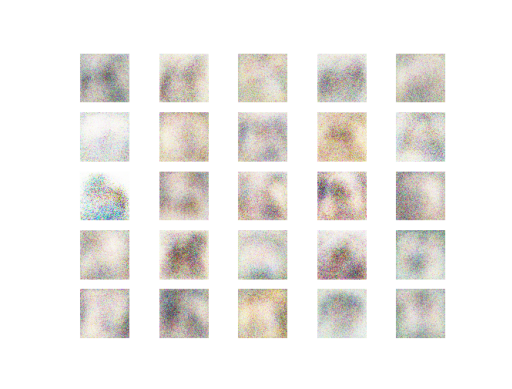

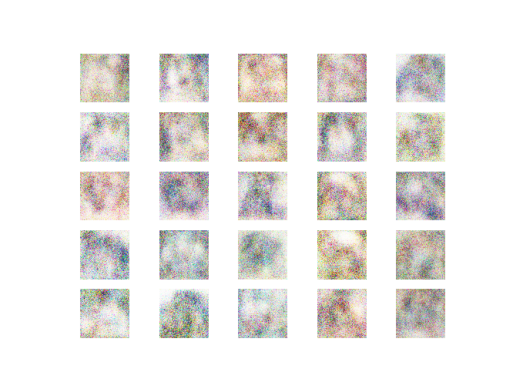

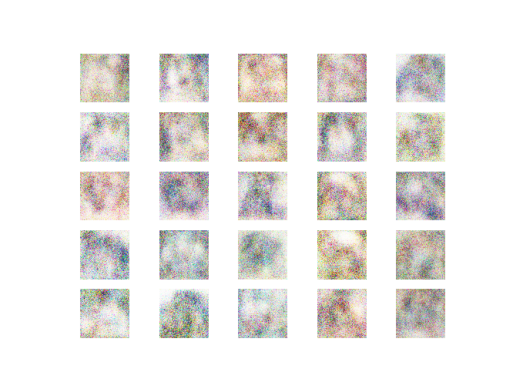

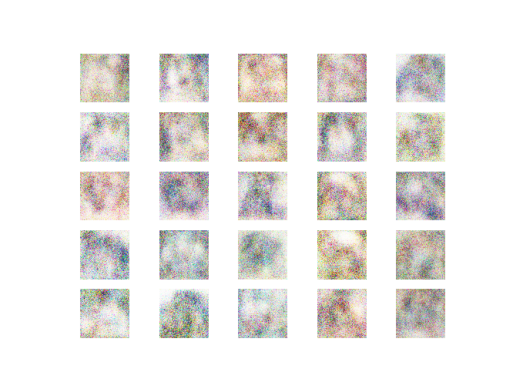

In [36]:

# List all files in the unzipped directory
dogfolder_out = './images'
file_list = os.listdir(dogfolder_out)
print(f"Total images: {len(file_list)} 🖼️")

# Display a few images
for _ in range(4):
    img_path = os.path.join(dogfolder_out, random.choice(file_list))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


#Discussion/Conclusion
Due to the high computational cost, we couldn't do multiple trials and errors. But, we did manage to generate images that resemble dogs through the process.